<a href="https://colab.research.google.com/github/MuellerLeonard/text-preprocessing/blob/main/text_to_vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clone git

In [19]:
!git clone https://github.com/MuellerLeonard/text-preprocessing.git

Cloning into 'text-preprocessing'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 12 (delta 2), reused 12 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (12/12), 888.42 KiB | 15.59 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [20]:
!ls text-preprocessing/

processed_text_df.csv  showcase.csv	      text_corpus_clean.txt
README.md	       StopWords_Generic.txt


Imports

In [21]:
import pandas as pd

In [22]:
path = "/content/text-preprocessing/processed_text_df.csv"
text_df = pd.read_csv(path, index_col=0)
print(text_df.head(1))

   item 5  item 4  item 5.02  item 7  item 8.01 item 9.01  item 7.01  \
0     NaN     NaN        NaN     NaN        NaN       NaN        NaN   

  item 5.07  item 2.02  item 3.02  ...  \
0       NaN        NaN        NaN  ...   

                                      part_2_item_1a  Adj Close  \
0  item . risk factors risks uncertainties and ot...  76.549049   

   Stock movement 1  Stock movement 7  Stock movement 30  Filing      Time  \
0         75.598679         77.384247            74.5989    True  16:08:06   

     10  Ticker        Date  
0  True       A  2019-03-05  

[1 rows x 51 columns]


In [23]:
def read_clean_text_corpus():
  """
  read from file

  Returns:
    - text (string): file content
  """
  with open("/content/text-preprocessing/text_corpus_clean.txt", "r") as f:
    text = f.read()

  return text

# Train a word2vec model

In [24]:
!pip install gensim

In [25]:
import re

# Your sentence delimiters
delimiters = r'[.!?;:\n]'

# Think about removing stop words and Company Names and Most common phrases to improve the model

def preprocess_text(corpus):
  """
  preprocess the text for Word2Vec, based on sentence context windows

  Args:
    - corpus (string): input text

  Returns:
    - tokenized_sentences (List[string]): List tokens with sentence length
  """
  # Split text into sentences based on the delimiters
  sentences = re.split(delimiters, corpus)
  # Tokenize each sentence into words
  tokenized_sentences = [sentence.strip().lower().split() for sentence in sentences if sentence.strip()]
  return tokenized_sentences

In [26]:
from gensim.models import Word2Vec

# Preprocessed sentences from corpus
tokenized_sentences = preprocess_text(read_clean_text_corpus())

# Train Word2Vec
model = Word2Vec(
    sentences=tokenized_sentences,
    vector_size=16,   # Size of the embedding #8 works, 16 works thats 1:1 and 16 is decent information-loss wise
    window=5,         # Context window
    min_count=5,      # Minimum frequency threshold
    sg=1,             # Use Skip-gram
    workers=4         # Adjust based on CPU
)

# Save the model
# adjust path
model.save("/content/text-preprocessing/word2vec_model.model")

## Create an average document vector

In [27]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')

import numpy as np

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [28]:
from gensim.models import Word2Vec
model = Word2Vec.load("/content/text-preprocessing/word2vec_model.model")

In [29]:
def get_document_vector(document):
    """
    Create an average document vector for a given document using a trained Word2Vec model.

    Args:
      - model (gensim.models): Trained Word2Vec model
      - document (string): The document text

    Returns:
      - average_vector (np.ndarray): A NumPy array representing the average document vector
    """
    # Tokenize the document
    # Use nltk
    word_tokens = word_tokenize(document)

    # Initialize a list to store word vectors
    word_vectors = []

    # Iterate over words in the document
    for token in word_tokens:
        # If the word exists in the Word2Vec model's vocabulary, get its vector
        if token in model.wv:
            word_vectors.append(model.wv[token])

    # If no words in the document were found in the model's vocabulary, return a zero vector
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)

    # Calculate the average vector of all word vectors in the document
    # Different logic possible here
    average_vector = np.mean(word_vectors, axis=0)

    return average_vector

### Exclude columns

- non text
- or text because of other reasons

In [30]:
metadata_items = ['Adj Close', 'Stock movement 1', 'Stock movement 7', 'Stock movement 30', 'Filing', 'Time', '10', 'Ticker', 'Date'] # 'Adj Close next day',

### Create an extra column inside the DataFrame

- for each text column an individual average vector
- summarized document vector over all text columns in a row

In [31]:
def get_text(row):
  """
  based on cell entries inside a DataFrame create average document vectors

  Args:
    - row (pd.Series): row of Dataframe

  Returns:
    - row (pd.Series): row of a DataFrame with added columns containing document vectors
  """
  # for loop over each column in row if not nan get text and pass it to another function
  columns = list(row.index)
  avg_doc_vecs = []
  for col in columns:
    if pd.notna(row[col]) and col not in metadata_items:
      new_col = "avg_vector " + col
      row[new_col] = get_document_vector(row[col])
      avg_doc_vecs.append(row[new_col])

  if avg_doc_vecs:
    final_average_vector = np.mean(avg_doc_vecs, axis=0)
    row['summarized_doc_vector'] = final_average_vector
  else:
    row['summarized_doc_vector'] = np.zeros(model.vector_size)

  return row

processed_text_df = text_df.apply(get_text, axis=1)

inspect

In [32]:
columns = list(processed_text_df.columns)

vector_pattern = r"(?i)^avg_vector"

vector_columns = [col for col in columns if re.search(vector_pattern, col)]

columns_to_keep = ['summarized_doc_vector'] + vector_columns + metadata_items

document_vector_df = processed_text_df[columns_to_keep]

print(document_vector_df.head(1))

                               summarized_doc_vector avg_vector item 5.07  \
0  [-0.34412006, -0.38276023, 0.13111445, 0.30518...                  NaN   

  avg_vector item 9.01                           avg_vector part_1_item_2  \
0                  NaN  [-0.47748625, -0.4620712, 0.112383775, 0.23478...   

                           avg_vector part_2_item_1a  Adj Close  \
0  [-0.21075387, -0.30344924, 0.14984514, 0.37559...  76.549049   

   Stock movement 1  Stock movement 7  Stock movement 30  Filing      Time  \
0         75.598679         77.384247            74.5989    True  16:08:06   

     10 Ticker        Date  
0  True      A  2019-03-05  


## Save the DataFrame

In [33]:
document_vector_df.to_csv("/content/text-preprocessing/document_vector_df16dim.csv")

## Evaluation

In [34]:
# test this on the name of an organisation to find out if the model is any good like tesla
print(model.wv.most_similar('money')) #fraud: good for thesis
#model.wv.doesnt_match([...])

vocab = []

for word in model.wv.index_to_key:
  vocab.append(word)

print("VOCAB length: ", len(vocab))
print("VOCAB most common words: ", vocab[0:20])
print("VOCAB rare words: ", vocab[-20:])

[('reduction', 0.9943670630455017), ('greater', 0.9940620064735413), ('repatriated', 0.9931126236915588), ('balance', 0.9929667711257935), ('instrument', 0.9924654364585876), ('performed', 0.9918394088745117), ('whether', 0.9915699362754822), ('judgment', 0.9913707971572876), ('elected', 0.9911209344863892), ('highly', 0.9905267357826233)]
VOCAB length:  935
VOCAB most common words:  ['and', 'the', 'of', 'to', 'our', 'in', 'number', 'we', 'or', 'for', 'a', 'on', 'date', 'may', 'tax', 'as', 'could', 'be', 'by', 'are']
VOCAB rare words:  ['materials', 'alternate', 'course', 'deliver', 'expectations', 'extension', 'depending', 'balanced', 'alternative', 'amortization', 'grew', 'improve', 'led', 'obtaining', 'sheet', 'assess', 'december', 'fees', 'throughout', 'believe']


In [35]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [36]:
def tsne_plot(model):
    """
    Creates and TSNE model and plots it, to create a visual map of similarity of the vectors

    Args:
      - model (gensim.models): gensim Word2Vec model

    Returns:
      - plt: plot that shows high dimensional vectors inside a two dimensional setting
    """
    labels = []
    tokens = []

    for word in model.wv.index_to_key:
        tokens.append(model.wv[word])
        labels.append(word)

    # Convert tokens to a NumPy array
    tokens_array = np.array(tokens)

    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', max_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens_array)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.savefig("/content/text-preprocessing/tsne_plot")

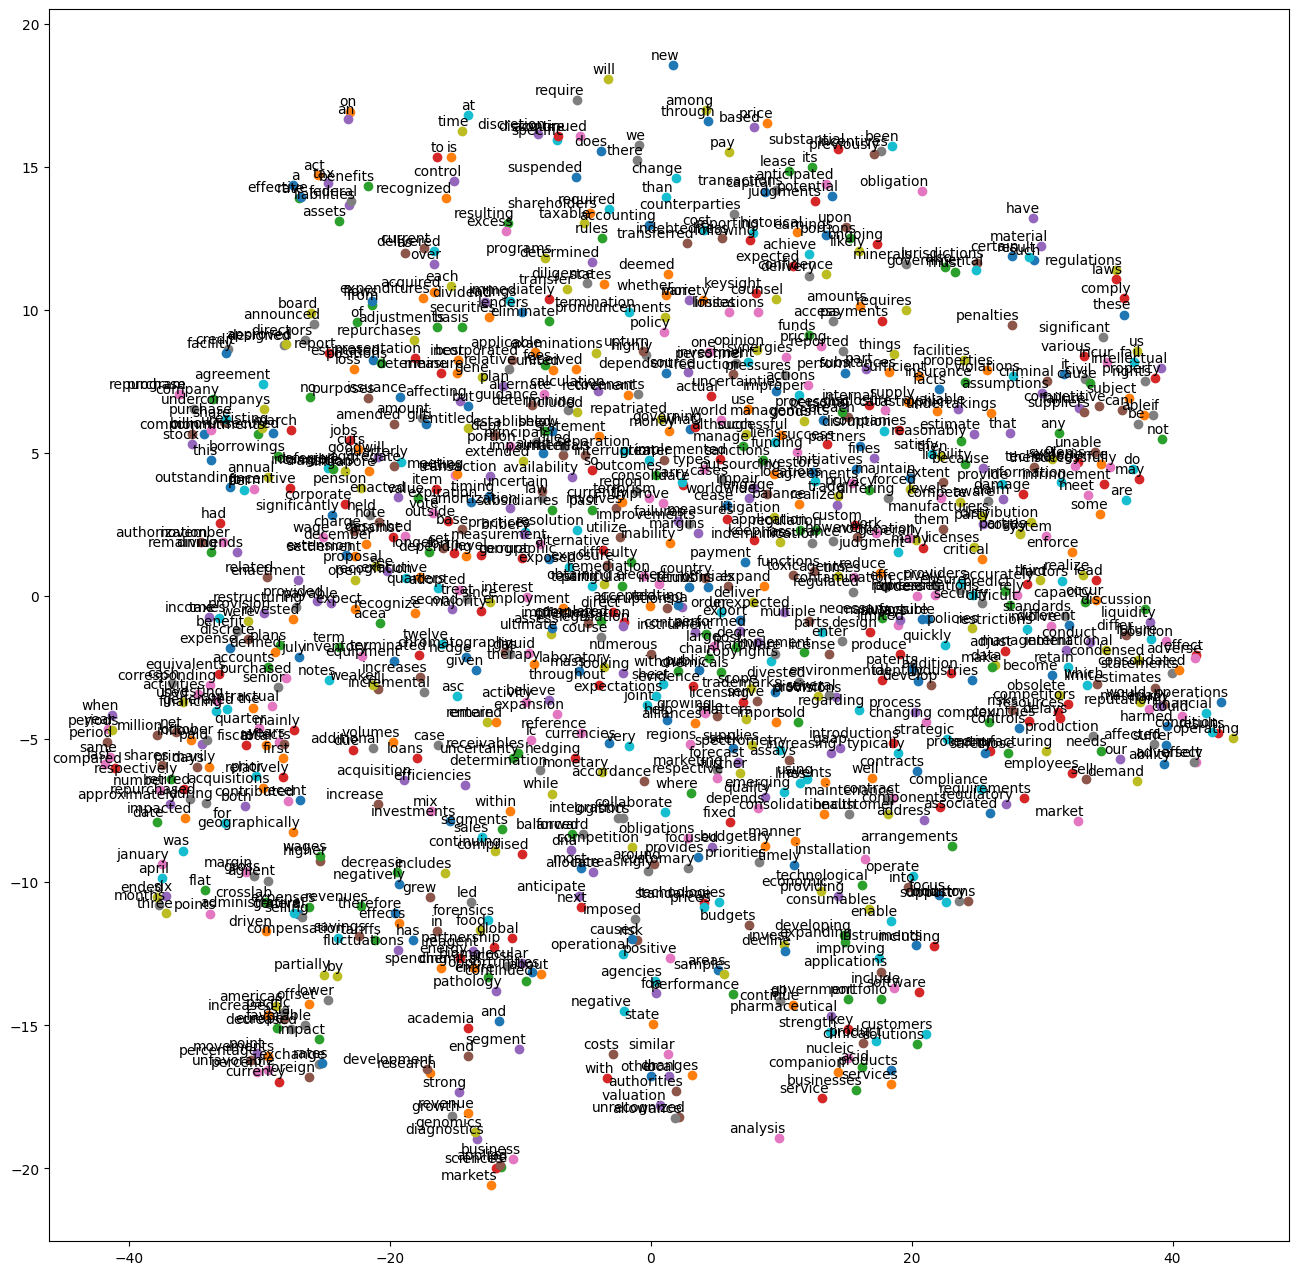

In [37]:
tsne_plot(model)

## Possibility of further processing with an autoencoder